In [ ]:
# ==========================================
# 1. Standard Library & Utilities
# ==========================================
import re
import string
import pprint

# ==========================================
# 2. Data Manipulation & NLP
# ==========================================
import pandas as pd
import numpy as np

# ==========================================
# 3. Visualization
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ==========================================
# 4. Scikit-Learn: Core & Preprocessing
# ==========================================
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# ==========================================
# 5. Scikit-Learn: Models
# ==========================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB 
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# ==========================================
# 6. Scikit-Learn: Metrics
# ==========================================
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    average_precision_score,  # PR-AUC
    f1_score,
    precision_score,
    recall_score
)


## 2. Baseline Model Building
1. Train/Test Split
    - Use Stratified Split to maintain class distribution in both sets.
    - Split ratio: 70/15/15 (train/validation/test).
2. Feature Extraction(Vectorization)
    - Use TF-IDF to convert the combined text column into numerical features.
    - Test with CountVectorizer as well to see if it improves performance.
3. Baseline Models
    - Logistic Regression for its simplicity and interpretability.
    - Naive Bayes for its effectiveness in text classification tasks.
4. Evaluation Metrics
    - PR-AUC
    - fraud class F1-score
    - fraud class recall
    - confusion matrix

In [30]:
df = pd.read_csv('/Users/596031367qq.com/UWO/unstructured data/Fake_job_detection/data/fake_job_postings_processed_1.csv')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text,length,clean_text
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,...,0,Other,Internship,NaN,NaN,Marketing,0,marketing intern were food52 and weve created ...,2587,marketing intern food52 ve create groundbreaki...
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,...,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,customer service cloud video production 90 sec...,5510,customer service cloud video production 90 sec...
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,...,0,NaN,NaN,NaN,NaN,NaN,0,commissioning machinery assistant cma valor se...,2585,commission machinery assistant cma valor servi...
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,...,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,account executive washington dc our passion fo...,5358,account executive washington dc passion improv...
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,...,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,bill review manager spotsource solutions llc i...,3770,bill review manager spotsource solution llc gl...


In [31]:
classifiers = {
    'log_reg': LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    'nb':      MultinomialNB(), 
    'svm':     LinearSVC(class_weight='balanced', max_iter=2000), 
    'rf':     RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)
}

In [32]:
# Stratified Split by 70/15/15
X_train, X_temp, y_train, y_temp = train_test_split(df['clean_text'], df['fraudulent'], test_size=0.3, stratify=df['fraudulent'], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


### 3.1 Logstic Regression and Naive Bayes by TF-IDF

In [33]:
def evaluate_on_val(model, Xva, y_val, threshold=0.5):
    """Return PR-AUC + fraud metrics using a decision threshold."""
    # Use predict_proba when available, else decision_function
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(Xva)[:, 1]
    else:
        scores = model.decision_function(Xva)

    y_pred = (scores >= threshold).astype(int)

    metrics = {
        "PR_AUC": average_precision_score(y_val, scores),
        "fraud_precision": precision_score(y_val, y_pred, zero_division=0),
        "fraud_recall": recall_score(y_val, y_pred, zero_division=0),
        "fraud_F1": f1_score(y_val, y_pred, zero_division=0),
        "threshold": threshold,
    }
    return metrics, scores


In [44]:
# 3.1.1
# Define Logistic Pipeline
lr_tf = Pipeline([          
    ('vectorizer', TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )),  
    ('classifier', classifiers['log_reg'])    
])

lr_tf.fit(X_train, y_train)
y_pred = lr_tf.predict(X_val)
lr_tf_metrics, lr_tf_val_scores = evaluate_on_val(lr_tf, X_val, y_val, threshold=0.5)
print("\n[Logistic Regression | Validation @ 0.50]")
pprint.pprint(lr_tf_metrics)


[Logistic Regression | Validation @ 0.50]
{'PR_AUC': np.float64(0.9365710274915041),
 'fraud_F1': 0.8846153846153846,
 'fraud_precision': 0.8846153846153846,
 'fraud_recall': 0.8846153846153846,
 'threshold': 0.5}


In [45]:
def tune_threshold(model, X_val, y_val):
    """Find the best threshold for maximizing fraud F1 score."""
    
    thresholds = np.arange(0.1, 1.01, 0.05)   # 0.1, 0.15, ..., 1.0
    scores = model.predict_proba(X_val)[:, 1]  # fraud probability

    rows = []
    for t in thresholds:
        y_pred = (scores >= t).astype(int)

        rows.append({
            "threshold": float(t),
            "PR_AUC": float(average_precision_score(y_val, scores)),
            "precision": float(precision_score(y_val, y_pred, zero_division=0)),
            "recall": float(recall_score(y_val, y_pred, zero_division=0)),
            "f1": float(f1_score(y_val, y_pred, zero_division=0)),
        })

    table = pd.DataFrame(rows).sort_values("threshold")

    # pick the row with max F1
    best_row = table.loc[table["f1"].idxmax()]

    return table, best_row

In [46]:
table_lr, best_lr = tune_threshold(lr_tf, X_val, y_val)
print("=== Threshold sweep (LR TF-IDF) ===")
print(table_lr.round(4))
print(best_lr)

=== Threshold sweep (LR TF-IDF) ===
    threshold  PR_AUC  precision  recall      f1
0        0.10  0.9366     0.1230  0.9923  0.2188
1        0.15  0.9366     0.2042  0.9692  0.3373
2        0.20  0.9366     0.3197  0.9615  0.4798
3        0.25  0.9366     0.4256  0.9462  0.5871
4        0.30  0.9366     0.5281  0.9385  0.6759
5        0.35  0.9366     0.6269  0.9308  0.7492
6        0.40  0.9366     0.7256  0.9154  0.8095
7        0.45  0.9366     0.7852  0.9000  0.8387
8        0.50  0.9366     0.8846  0.8846  0.8846
9        0.55  0.9366     0.9487  0.8538  0.8988
10       0.60  0.9366     0.9730  0.8308  0.8963
11       0.65  0.9366     0.9811  0.8000  0.8814
12       0.70  0.9366     1.0000  0.7769  0.8745
13       0.75  0.9366     1.0000  0.7538  0.8596
14       0.80  0.9366     1.0000  0.7000  0.8235
15       0.85  0.9366     1.0000  0.6538  0.7907
16       0.90  0.9366     1.0000  0.5231  0.6869
17       0.95  0.9366     1.0000  0.3077  0.4706
18       1.00  0.9366     0.0000 

In [84]:
t = best_lr["threshold"]
scores_lr_tf = lr_tf.predict_proba(X_val)[:, 1]
pred_lr_tf = (scores_lr_tf >= t).astype(int)
# export predicted to csv
test_results = pd.DataFrame({
    "text": X_val,
    "true_label": y_val,
    "predicted_label": pred_lr_tf,
    "fraud_probability": scores_lr_tf
})
test_results.to_csv("/Users/596031367qq.com/UWO/unstructured data/Fake_job_detection/data/lr_tf_val_predictions.csv", index=False)

In [87]:
import joblib
save_path = "/Users/596031367qq.com/UWO/unstructured data/Fake_job_detection/data/lr_best_model.pkl"
joblib.dump(lr_tf,  save_path)


['/Users/596031367qq.com/UWO/unstructured data/Fake_job_detection/data/lr_best_model.pkl']

In [37]:
# 3.1.2 NB
nb_tf = Pipeline([          
    ('vectorizer', TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )),  
    ('classifier', classifiers['nb'])    
])
nb_tf.fit(X_train, y_train)
nb_tf_metrics, nb_val_scores = evaluate_on_val(nb_tf, X_val, y_val, threshold=0.5)
print("\n[MultinomialNB | Validation @ 0.50]")
print(nb_tf_metrics)


[MultinomialNB | Validation @ 0.50]
{'PR_AUC': np.float64(0.6530693405514715), 'fraud_precision': 1.0, 'fraud_recall': 0.13076923076923078, 'fraud_F1': 0.23129251700680273, 'threshold': 0.5}


### 3.2 Logistic Regression and Naive Bayes by CountVectorizer

In [38]:
# 3.2.1 Logistic with CountVectorizer
lr_cv = Pipeline([          
    ('vectorizer',CountVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        stop_words="english",   
    )),  
    ('classifier', classifiers['log_reg'])    
])
lr_cv.fit(X_train, y_train)
lr_cv_metrics, lr_cv_val_scores = evaluate_on_val(lr_cv, X_val,y_val, threshold=0.5)
print("\n[Logistic Regression (CountVectorizer) | Validation @ 0.50]")
print(lr_cv_metrics)


[Logistic Regression (CountVectorizer) | Validation @ 0.50]
{'PR_AUC': np.float64(0.9281133503393668), 'fraud_precision': 0.88, 'fraud_recall': 0.8461538461538461, 'fraud_F1': 0.8627450980392157, 'threshold': 0.5}


In [79]:
# 3.2.2 NB with CountVectorizer
nb_cv = Pipeline([          
    ('vectorizer', CountVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95,
        stop_words="english",   
    )),  
    ('classifier', classifiers['nb'])    
])
nb_calibrated = CalibratedClassifierCV(nb_cv, method='isotonic', cv=3)
nb_calibrated.fit(X_train, y_train)
nb_cv_metrics, nb_cv_val_scores = evaluate_on_val(nb_calibrated, X_val, y_val, threshold=0.5)
print("\n[MultinomialNB (CountVectorizer) | Validation @ 0.50]")
print(nb_cv_metrics)


[MultinomialNB (CountVectorizer) | Validation @ 0.50]
{'PR_AUC': np.float64(0.8586007412157781), 'fraud_precision': 0.9655172413793104, 'fraud_recall': 0.6461538461538462, 'fraud_F1': 0.7741935483870968, 'threshold': 0.5}


In [80]:
table_nb, best_nb = tune_threshold(nb_calibrated, X_val, y_val)
print("\n=== Threshold sweep (NB CountVec) ===")
print(table_nb.round(4))
print(best_nb)


=== Threshold sweep (NB CountVec) ===
    threshold  PR_AUC  precision  recall      f1
0        0.10  0.8586     0.6839  0.8154  0.7439
1        0.15  0.8586     0.7143  0.7692  0.7407
2        0.20  0.8586     0.7557  0.7615  0.7586
3        0.25  0.8586     0.7680  0.7385  0.7529
4        0.30  0.8586     0.8879  0.7308  0.8017
5        0.35  0.8586     0.9029  0.7154  0.7983
6        0.40  0.8586     0.9375  0.6923  0.7965
7        0.45  0.8586     0.9462  0.6769  0.7892
8        0.50  0.8586     0.9655  0.6462  0.7742
9        0.55  0.8586     0.9647  0.6308  0.7628
10       0.60  0.8586     0.9759  0.6231  0.7606
11       0.65  0.8586     0.9865  0.5615  0.7157
12       0.70  0.8586     0.9863  0.5538  0.7094
13       0.75  0.8586     0.9853  0.5154  0.6768
14       0.80  0.8586     0.9853  0.5154  0.6768
15       0.85  0.8586     1.0000  0.5154  0.6802
16       0.90  0.8586     1.0000  0.5154  0.6802
17       0.95  0.8586     0.0000  0.0000  0.0000
18       1.00  0.8586     0.00

### Conclude the results


In [41]:
all_metrics = {
    "Logistic Regression (TF-IDF)": lr_tf_metrics,
    "MultinomialNB (TF-IDF)": nb_tf_metrics,
    "Logistic Regression (CountVectorizer)": lr_cv_metrics,
    "MultinomialNB (CountVectorizer)": nb_cv_metrics
}
results = pd.DataFrame(all_metrics).T.reset_index().rename(columns={"index": "Model"})
results = results.sort_values(by="fraud_F1", ascending=False)
print(results)


                                   Model    PR_AUC  fraud_precision  \
0           Logistic Regression (TF-IDF)  0.936571         0.884615   
2  Logistic Regression (CountVectorizer)  0.928113         0.880000   
3        MultinomialNB (CountVectorizer)  0.895598         0.978495   
1                 MultinomialNB (TF-IDF)  0.653069         1.000000   

   fraud_recall  fraud_F1  threshold  
0      0.884615  0.884615        0.5  
2      0.846154  0.862745        0.5  
3      0.700000  0.816143        0.5  
1      0.130769  0.231293        0.5  


In [57]:
# Figure output: Distribution of predicted probabilities from the NB CountVectorizer model
# Added calibration to NB predictions, so these should be more meaningful probabilities now
# print(pd.Series(nb_cv_val_scores).describe())
# plt.figure(figsize=(10, 4))
# plt.hist(nb_cv_val_scores, bins=50, color='skyblue', edgecolor='black')
# plt.title("Distribution of Naive Bayes Predictions")
# plt.xlabel("Predicted Probability of Fraud")
# plt.ylabel("Count")
# plt.show()

### Strong Baselines:
    TF-IDF + Logistic Regression
    CountVec + Multinomial NB
### Best Threshold
- Logistic + TF: **0.60**
- NB + CountVec: **0.30**

## Stronger Classical Models
1. Support Vector Machines (SVM)
    - Linear SVM for high-dimensional text data.
2. Random Forests

In [62]:
svm = Pipeline([          
    ('vectorizer', TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )),  
    ('classifier', classifiers['svm'])    
])
svm_cal = CalibratedClassifierCV(svm, method="sigmoid", cv=3)  
svm_cal.fit(X_train, y_train)
# validation @ 0.5
svm_metrics, svm_scores = evaluate_on_val(svm_cal, X_val, y_val, threshold=0.5)
print("[Linear SVM | TF-IDF | Validation @ 0.50]")
print(svm_metrics)

[Linear SVM | TF-IDF | Validation @ 0.50]
{'PR_AUC': np.float64(0.9496177597418793), 'fraud_precision': 0.990909090909091, 'fraud_recall': 0.8384615384615385, 'fraud_F1': 0.9083333333333333, 'threshold': 0.5}


In [63]:
svm_table, svm_best = tune_threshold(svm_cal, X_val, y_val)
print("=== Threshold sweep (SVM TF-IDF) ===")
print(svm_table.round(4))
print("\n=== Best SVM threshold by F1 ===")
print(svm_best)

=== Threshold sweep (SVM TF-IDF) ===
    threshold  PR_AUC  precision  recall      f1
0        0.10  0.9496     0.7610  0.9308  0.8374
1        0.15  0.9496     0.8264  0.9154  0.8686
2        0.20  0.9496     0.8864  0.9000  0.8931
3        0.25  0.9496     0.9206  0.8923  0.9062
4        0.30  0.9496     0.9587  0.8923  0.9243
5        0.35  0.9496     0.9583  0.8846  0.9200
6        0.40  0.9496     0.9569  0.8538  0.9024
7        0.45  0.9496     0.9821  0.8462  0.9091
8        0.50  0.9496     0.9909  0.8385  0.9083
9        0.55  0.9496     1.0000  0.8308  0.9076
10       0.60  0.9496     1.0000  0.8308  0.9076
11       0.65  0.9496     1.0000  0.8077  0.8936
12       0.70  0.9496     1.0000  0.7692  0.8696
13       0.75  0.9496     1.0000  0.7231  0.8393
14       0.80  0.9496     1.0000  0.7077  0.8288
15       0.85  0.9496     1.0000  0.6923  0.8182
16       0.90  0.9496     1.0000  0.6692  0.8018
17       0.95  0.9496     1.0000  0.6385  0.7793
18       1.00  0.9496     0.0000

In [64]:
rf_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )),  
    ('classifier', classifiers['rf'])
])
rf_pipeline.fit(X_train, y_train)

rf_metrics, rf_scores = evaluate_on_val(rf_pipeline,X_val, y_val, threshold=0.5)
print("[Random Forest | TF-IDF | Validation @ 0.50]")
print(rf_metrics)



[Random Forest | TF-IDF | Validation @ 0.50]
{'PR_AUC': np.float64(0.9207186016818496), 'fraud_precision': 0.9770114942528736, 'fraud_recall': 0.6538461538461539, 'fraud_F1': 0.783410138248848, 'threshold': 0.5}


In [66]:
rf_table, rf_best = tune_threshold(rf_pipeline, X_val, y_val)
print("=== Threshold sweep (RF TF-IDF) ===")
print(rf_table.round(4))
print("\n=== Best RF threshold by F1 ===")  
print(rf_best)


=== Threshold sweep (RF TF-IDF) ===
    threshold  PR_AUC  precision  recall      f1
0        0.10  0.9207     0.5516  0.9462  0.6969
1        0.15  0.9207     0.6744  0.8923  0.7682
2        0.20  0.9207     0.7943  0.8615  0.8266
3        0.25  0.9207     0.9060  0.8154  0.8583
4        0.30  0.9207     0.9528  0.7769  0.8559
5        0.35  0.9207     0.9608  0.7538  0.8448
6        0.40  0.9207     0.9600  0.7385  0.8348
7        0.45  0.9207     0.9783  0.6923  0.8108
8        0.50  0.9207     0.9767  0.6462  0.7778
9        0.55  0.9207     0.9765  0.6385  0.7721
10       0.60  0.9207     0.9875  0.6077  0.7524
11       0.65  0.9207     0.9873  0.6000  0.7464
12       0.70  0.9207     0.9867  0.5692  0.7220
13       0.75  0.9207     1.0000  0.5077  0.6735
14       0.80  0.9207     1.0000  0.4769  0.6458
15       0.85  0.9207     1.0000  0.4308  0.6022
16       0.90  0.9207     1.0000  0.3692  0.5393
17       0.95  0.9207     1.0000  0.2462  0.3951
18       1.00  0.9207     0.0000 

### Best Threshold for SVM and RF
- SVM + TF: **0.30**
- RF + TF: **0.25**

In [67]:
t = svm_best["threshold"]
scores_val = svm_cal.predict_proba(X_val)[:, 1]
pred_val   = (scores_val >= t).astype(int)
# export predicted to csv
test_results = pd.DataFrame({
    "text": X_val,
    "true_label": y_val,
    "predicted_label": pred_val,
    "fraud_probability": scores_val
})
test_results.to_csv("/Users/596031367qq.com/UWO/unstructured data/Fake_job_detection/data/svm_val_predictions.csv", index=False)

In [ ]:
save_path = "/Users/596031367qq.com/UWO/unstructured data/Fake_job_detection/data/svm_best_model.pkl"
joblib.dump(svm_cal,  save_path)


['/Users/596031367qq.com/UWO/unstructured data/Fake_job_detection/data/svm_best_model.pkl']

In [68]:
t = rf_best["threshold"]
scores_val = rf_pipeline.predict_proba(X_val)[:, 1]
pred_val   = (scores_val >= t).astype(int)
# export predicted to csv
test_results = pd.DataFrame({
    "text": X_val,
    "true_label": y_val,    
    "predicted_label": pred_val,
    "fraud_probability": scores_val
})
test_results.to_csv("/Users/596031367qq.com/UWO/unstructured data/Fake_job_detection/data/rf_val_predictions.csv", index=False)

### Grid search for hyperparameter tuning
- SVM: C parameter
- RF: number of trees, max depth
我们在 Random Forest 上尝试了 Grid Search 来限制树的深度 (max_depth=[30, 50]) 以防止过拟合。然而，实验结果显示 F1 分数从 0.84 下降到了 0.66。这表明对于高维稀疏的文本数据 (TF-IDF)，决策树需要更大的深度来捕捉细微的语义特征。因此，我们最终决定保留无深度限制 (max_depth=None) 的模型结构。

In [ ]:
# 1. define Pipeline
pipe_rf = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 2), max_features=5000)), 
    ('classifier', RandomForestClassifier(class_weight='balanced_subsample', random_state=42))
])

# 2. define parameters
param_grid_rf = {
    'classifier__n_estimators': [100, 300],      
    'classifier__max_depth': [None, 30, 50],     
    'classifier__min_samples_split': [2, 5, 10]  
}

# 3. grid search
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=3, scoring='f1', n_jobs=-1, verbose=1)

grid_rf.fit(X_train, y_train)

print("RF best parameters:", grid_rf.best_params_)
print("RF best score:", grid_rf.best_score_)

正在搜索最佳 RF 参数... (⚠️这个会比较慢，去喝杯咖啡吧☕️)
Fitting 3 folds for each of 18 candidates, totalling 54 fits
✅ RF 最佳参数: {'classifier__max_depth': 30, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
✅ RF 最佳分数: 0.660406263200353


In [60]:
# 1. Define Pipeline
pipe_svm = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
    ('classifier', LinearSVC(class_weight='balanced', random_state=42, max_iter=2000))
])

# 2. define parameters
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__loss': ['hinge', 'squared_hinge']
}

# 3. search
print("searching best SVM parameters...")
grid_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=3, scoring='f1', n_jobs=-1, verbose=1)

grid_svm.fit(X_train, y_train)

print("✅ SVM best parameters:", grid_svm.best_params_)
print("✅ SVM best score:", grid_svm.best_score_)

searching best SVM parameters...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


KeyboardInterrupt: 

# **Fit the models on the test data**

In [77]:
t = best_lr["threshold"]
scores_lr = lr_tf.predict_proba(X_test)[:, 1]
pred_lr  = (scores_lr >= t).astype(int)

print("=== LR (TF-IDF) TEST ===")
print("PR-AUC:", average_precision_score(y_test, scores_lr))
print("precision:", precision_score(y_test, pred_lr, zero_division=0))
print("recall:", recall_score(y_test, pred_lr, zero_division=0))
print("F1:", f1_score(y_test, pred_lr, zero_division=0))

=== LR (TF-IDF) TEST ===
PR-AUC: 0.9088808807350561
precision: 0.8629032258064516
recall: 0.823076923076923
F1: 0.84251968503937


In [ ]:
t = best_nb["threshold"]
scores_nb = nb_cv.predict_proba(X_test)[:, 1]
pred_nb = (scores_nb >= t).astype(int)

print("=== NB (CV) TEST ===")
print("NB TEST PR-AUC:", average_precision_score(y_test, scores_nb))
print("NB TEST precision:", precision_score(y_test, pred_nb, zero_division=0))
print("NB TEST recall:", recall_score(y_test, pred_nb, zero_division=0))
print("NB TEST F1:", f1_score(y_test, pred_nb, zero_division=0))

NotFittedError: Pipeline is not fitted yet.

In [82]:
t = svm_best["threshold"]
scores_svm = svm_cal.predict_proba(X_test)[:, 1]
pred_svm  = (scores_svm >= t).astype(int)
print("=== SVM TEST ===")
print("SVM TEST PR-AUC:", average_precision_score(y_test, scores_svm))
print("SVM TEST precision:", precision_score(y_test, pred_svm, zero_division=0))
print("SVM TEST recall:", recall_score(y_test, pred_svm, zero_division=0))
print("SVM TEST F1:", f1_score(y_test, pred_svm, zero_division=0))

=== SVM TEST ===
SVM TEST PR-AUC: 0.9326722459868846
SVM TEST precision: 0.9032258064516129
SVM TEST recall: 0.8615384615384616
SVM TEST F1: 0.8818897637795275


<Axes: >

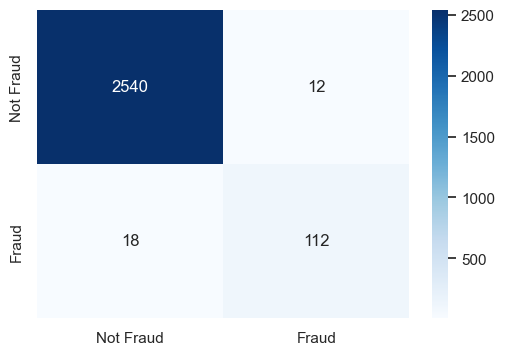

In [83]:
# Plot confusion matrix for SVM
cm = confusion_matrix(y_test, pred_svm)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud']) 

In [ ]:
t = rf_best["threshold"]
scores_rf = rf_pipeline.predict_proba(X_test)[:, 1]
pred_rf   = (scores_rf >= t).astype(int)

print("=== RF TEST ===")
print("PR-AUC:", average_precision_score(y_test, scores_rf))
print("precision:", precision_score(y_test, pred_rf, zero_division=0))
print("recall:", recall_score(y_test, pred_rf, zero_division=0))
print("F1:", f1_score(y_test, pred_rf, zero_division=0))

=== RF TEST ===
PR-AUC: 0.8751368357924443
precision: 0.9270833333333334
recall: 0.6846153846153846
F1: 0.7876106194690266


<Axes: >

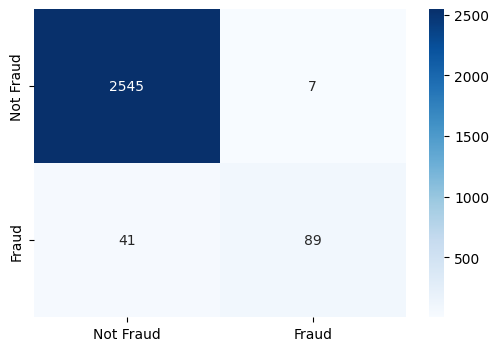

In [ ]:
# Plot confusion matrix for RF 
cm = confusion_matrix(y_test, pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud']) 